# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sklearn.compose import ColumnTransformer

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

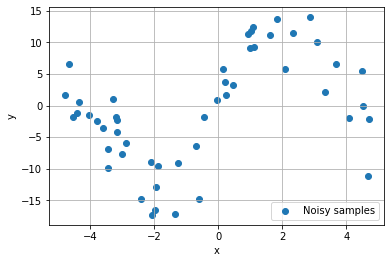

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

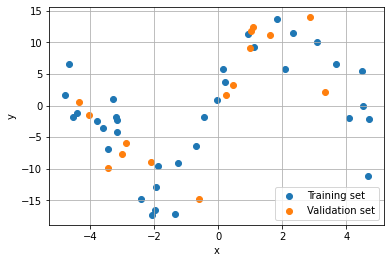

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

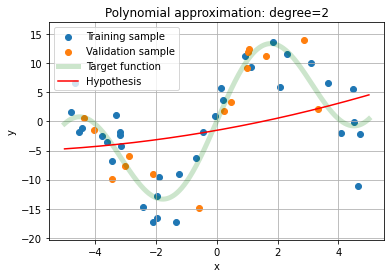

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

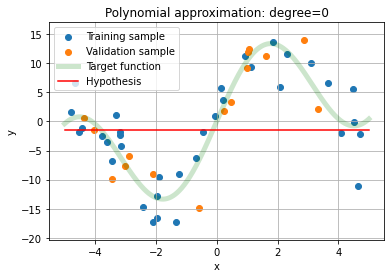

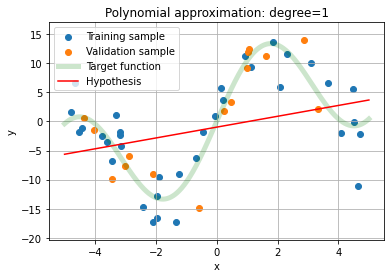

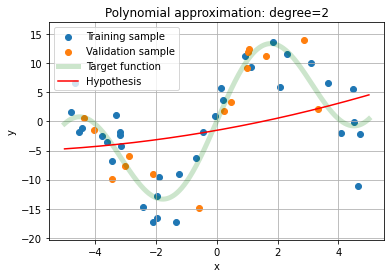

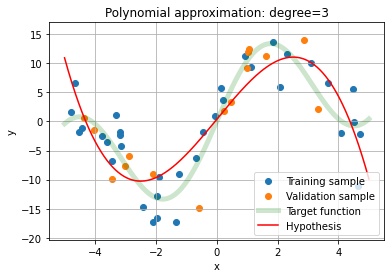

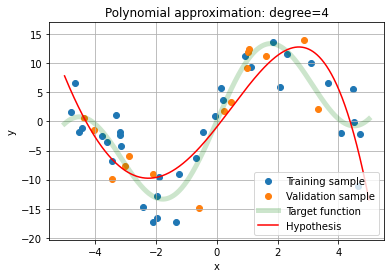

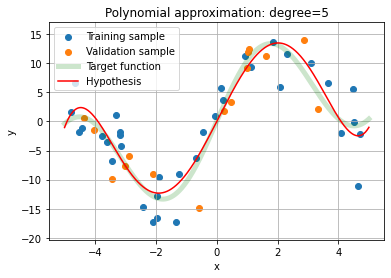

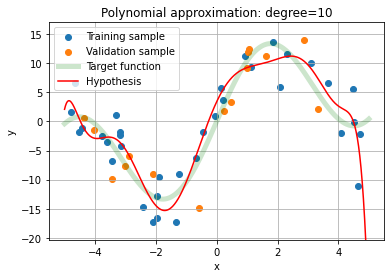

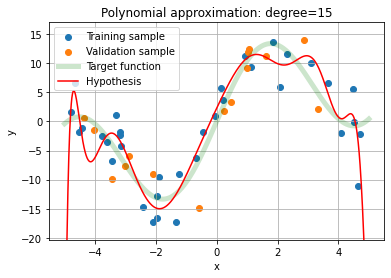

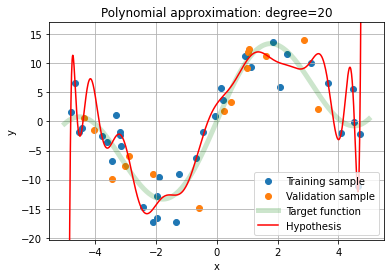

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

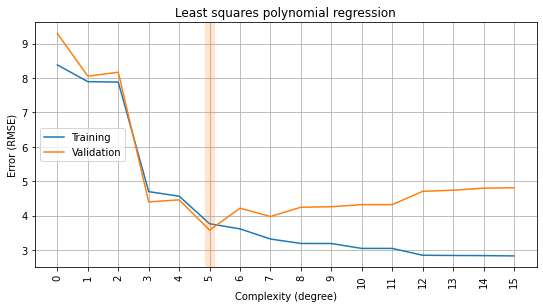

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph', y_bottom_lim=None, y_top_lim=None):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')     
    if y_top_lim:
        plt.ylim(top=y_top_lim)
    if y_bottom_lim:
        plt.ylim(bottom=y_bottom_lim)
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

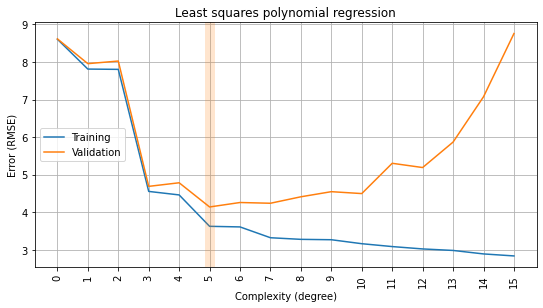

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

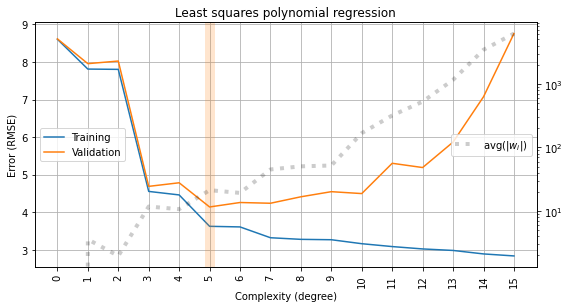

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

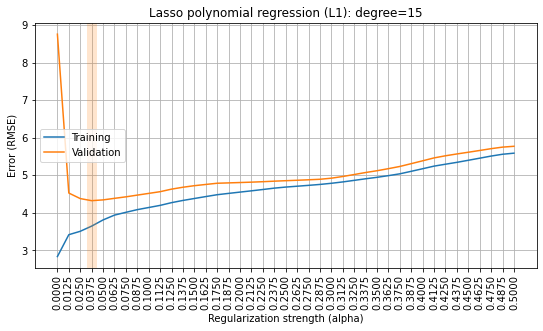

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

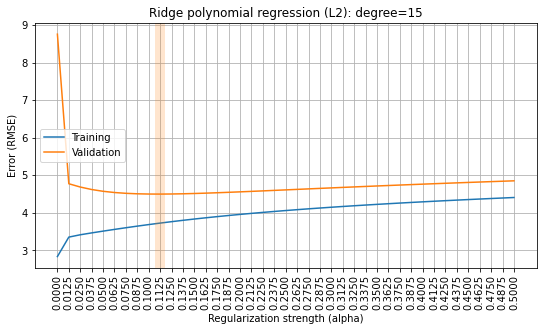

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

#### WARNING!

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you must collect all features together (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [21]:
def make_model_diabetes(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=300000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=300000) 
    
    polynomial_features = ['bmi', 'bp']

    polynomial_features_transformer = ColumnTransformer(transformers=[('pol_transformer', PolynomialFeatures(degree, include_bias=(degree == 0)), polynomial_features)],
                                     remainder='passthrough')
    
    return Pipeline([
        ('pol', polynomial_features_transformer),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

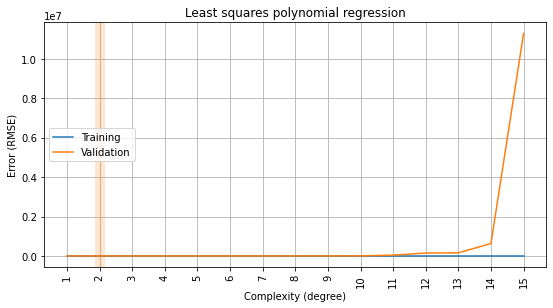

Wall time: 1.83 s


In [22]:
%%time
degrees = range(1, 16)
rmse_train, rmse_valid = [], []
for degree in degrees:
    results = cross_validate(make_model_diabetes(degree), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

plot_fitting_graph(degrees, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

#### *Let's take a look at the plot with another scale and print train-test scores*

[53.3414725879353, 52.63608853921647, 52.38950647309351, 52.18019337213205, 51.91537207345586, 51.61287980172921, 51.167882446388866, 50.410725120792975, 49.64924305976449, 48.72083557256475, 47.444941424930974, 45.79296612577207, 44.46320245926256, 42.86314116761107, 41.19992890917878]


[54.69171350506142, 54.4107335743371, 55.26370720610898, 56.07415231043164, 61.21289092631082, 74.97606961554379, 125.20148787085623, 516.6980067699653, 788.7527866369054, 2997.6890612711986, 40750.027598980734, 147591.19726762356, 156428.03046120773, 628755.8142487394, 11280098.31763875]


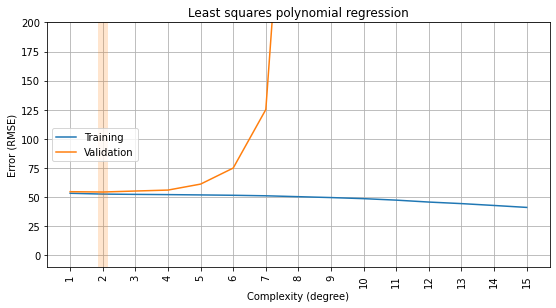

In [23]:
print(rmse_train)
print('\n')
print(rmse_valid)

plot_fitting_graph(degrees, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression', y_bottom_lim=-10, y_top_lim=200)

***We can see the following:***

- degree 1 has little underfitting because the fit for both train and valid datasetts is slightly worse than for optimal degree (2). It happens because model couldn't capture underlying dependency well.
- degree 2 is the sweet spot because it has good both train and valid metrics. Model can capture underlying distribution well.
- degrees > 2 have overfitting because despite the train error scores decrease the valid error scores increase. It happens because model starts fitting noise in train dataset. 

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

***Hypothesis: Regularization methods constraint the weigthts.
If the hypothesis is true we should see decreasing average of the weights when regularization parameter alpha increased.***

#### L1

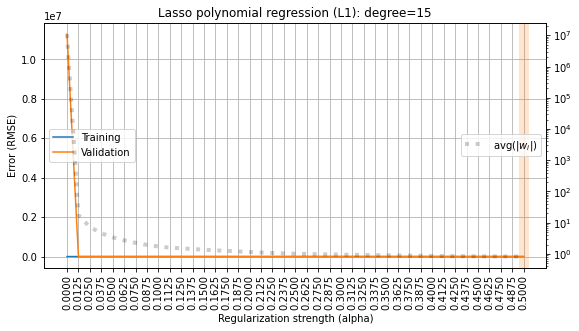

Wall time: 28.4 s


In [24]:
%%time
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_diabetes(degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        np.mean([            
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

In [25]:
print(rmse_train)

[41.19992890917878, 50.65912724003064, 51.14413171005785, 51.37431923356807, 51.51732550516351, 51.62165500486477, 51.70911133122115, 51.780195771599764, 51.836755013394836, 51.87615761256492, 51.902750341970695, 51.92934130060335, 51.95801545978437, 51.986083042583026, 52.009775603245465, 52.034459738227476, 52.06057104193154, 52.085253863297154, 52.10742539075325, 52.12677527795704, 52.142615428092164, 52.157137227218755, 52.17096846491734, 52.18332451300993, 52.19477967976011, 52.20501871729364, 52.21494305185195, 52.225211403826755, 52.23552543980533, 52.246197402169386, 52.25595812865696, 52.265356894957144, 52.27517696096601, 52.28397888587652, 52.2910546586278, 52.29769522418493, 52.30362862429653, 52.30872597927273, 52.31364917743677, 52.318379314441245, 52.32317038822574]


In [26]:
print(rmse_valid)

[11280098.31763875, 166.94749583027107, 103.97601702612292, 70.63001361296656, 70.5183244641594, 66.28980468869844, 64.47406329012071, 61.69330960962628, 59.50615250764812, 61.90251494736992, 61.40838092303752, 60.51245795994199, 59.452794271314815, 58.805925607357395, 58.99493613294338, 59.48797347320433, 60.04832984222342, 60.43169872564929, 60.89643633830635, 61.05773350733582, 61.078465569848085, 60.96763308981404, 60.8315290661029, 60.69017380850458, 60.50468319200841, 60.30590023493113, 60.104809036493315, 59.91029176003807, 59.6615043187177, 59.415261304538475, 59.18786362037663, 58.967722825503145, 58.65062305219004, 58.39379761977449, 58.12404128710866, 57.86686270183119, 57.656616016137306, 57.41562824062039, 57.17430779330857, 56.942886392545844, 56.721783329485426]


In [27]:
print(avg_coef)

[10867563.96005122, 17.473818274216924, 7.335239648134011, 4.611984443018196, 3.4128323341565854, 2.733550917394898, 2.2696602451428154, 1.9523666756605351, 1.7324631601869303, 1.5967125060257124, 1.5152245230357277, 1.441827600405385, 1.369662966941433, 1.3044228478836293, 1.2532804468914143, 1.203771362293169, 1.1547203633403584, 1.111106123081986, 1.074168073163148, 1.0436859810057673, 1.0199683840595886, 0.9993122927312607, 0.9805245350852794, 0.9644998949896543, 0.9502809304175563, 0.9381161065051172, 0.9268019562495068, 0.9155070528274308, 0.9045850713249102, 0.8936781515322488, 0.8840367651659115, 0.8750640113643542, 0.8659740113428169, 0.858059931257275, 0.8518878329347193, 0.8462585854959268, 0.8413694958299749, 0.8372825209201146, 0.8334398805046991, 0.8298392916421452, 0.8262876208595922]


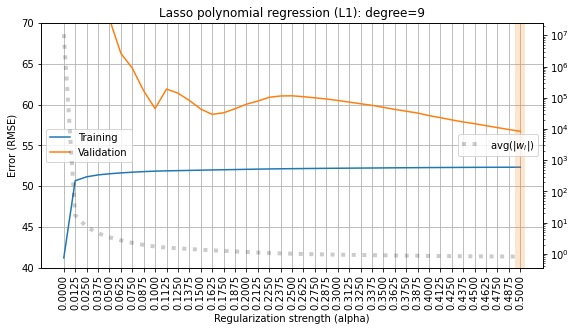

In [28]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=9', y_bottom_lim=40, y_top_lim=70)

#### L2

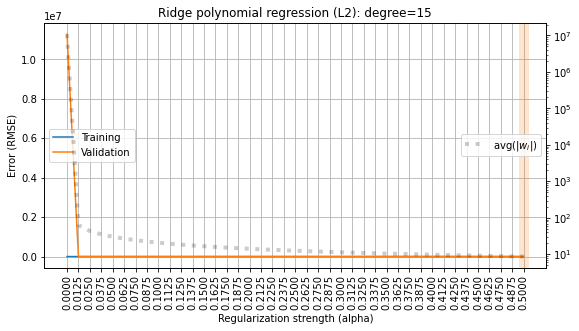

Wall time: 4.76 s


In [29]:
%%time
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_diabetes(degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        np.mean([            
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

In [30]:
print(rmse_train)

[41.19992890917878, 49.94556439026904, 50.21465328237856, 50.36397869111862, 50.46696550846421, 50.54525544753429, 50.60818407612872, 50.66063707746913, 50.7054942771748, 50.7445964363163, 50.77919160395761, 50.81016485178566, 50.83816648241604, 50.86368821193148, 50.88711076818274, 50.90873487885195, 50.92880215162741, 50.94750956069349, 50.965019753351065, 50.98146854514212, 50.996970476302735, 51.01162300180303, 51.0255096993984, 51.03870275957227, 51.05126494205148, 51.0632511304262, 51.07470958004281, 51.085682929035436, 51.09620902446346, 51.106321602682826, 51.116050853741754, 51.125423892719844, 51.13446515581035, 51.14319673509489, 51.15163866303336, 51.159809155446595, 51.167724820031296, 51.1754008360944, 51.18285111012775, 51.190088411001895, 51.19712448788681]


In [31]:
print(rmse_valid)

[11280098.31763875, 682.0904678901697, 436.30720853804235, 334.439273787942, 277.6427855939472, 241.19428530127706, 215.74466914497802, 196.93476445360392, 182.4481816715738, 170.937193039943, 161.56320657130541, 153.77659930991035, 147.20186926954054, 141.57360185729323, 136.6987967098608, 132.43369649686866, 128.66899195642364, 125.3200680798277, 122.32039305860935, 119.61692735969811, 117.16686661949193, 114.93528637724498, 112.89340963648422, 111.01731282950227, 109.28694572515842, 107.68537969383249, 106.19822445627048, 104.81317077669271, 103.51962843064173, 102.30843704618165, 101.17163325564209, 100.10226176720451, 99.09422099396892, 98.14213609376489, 97.2412539164487, 96.38735558216071, 95.57668334209792, 94.80587908291652, 94.07193237486247, 93.37213638790006, 92.70405032481708]


In [32]:
print(avg_coef)

[10867563.96005122, 63.00127480417207, 43.77786435430723, 35.4419121113973, 30.492011155038615, 27.070991072136593, 24.541334488586617, 22.564727262279245, 20.962574092439674, 19.6315411024981, 18.51210508967525, 17.552833458807502, 16.719950409248305, 15.989871247359506, 15.34373643588529, 14.770337851119422, 14.254482184483274, 13.785107395252535, 13.36012642065906, 12.975406199695097, 12.62079448508223, 12.292176278499884, 11.986836608444232, 11.701959389212938, 11.43667475964494, 11.188754405335509, 10.957653431008898, 10.740482608854883, 10.535705204789183, 10.342498107969707, 10.158811178941795, 9.983734301068688, 9.817526182554046, 9.659166978779734, 9.508447901329417, 9.36502395438377, 9.227393038436528, 9.095133761929413, 8.968069021077792, 8.846586290285762, 8.729757263618206]


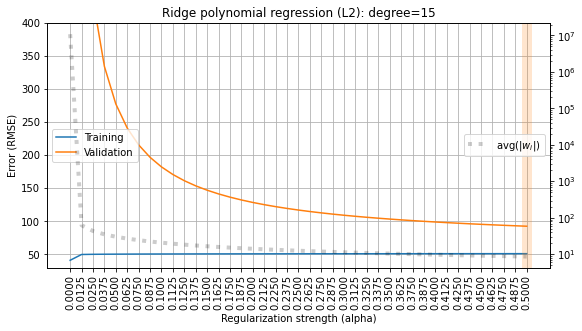

In [33]:
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15', y_bottom_lim=30, y_top_lim=400)

#### Summary

***We can see following:***

- average absolute weights sum decreases with increase of parameter alpha for both regularizations
- Optimal alpha values for L1 and L2 is 0.5
- Optimal alpha value is max of considered alphas. It is likely that checking alphas > 0.5 would decrease error on validation dataset.

Indeed we can see that both regularizations L1 and L2 constraint the weights because the average absolute values of weights decreases with increasing of regularization parameter alpha.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

***Hypothesis: L1 is more likely to produce zero coefficients.***

***Hypothesis is true if the number of zero coefficients for L1 will be more than the number of zero coefficents for L2***

#### L1

In [34]:
def count_zero_coefs(estimators):
    eps = np.finfo(np.float64).eps
    result = []
    for model in estimators:
        result.append(np.sum([coef == 0 for coef in model['reg'].coef_]))
    return result
    

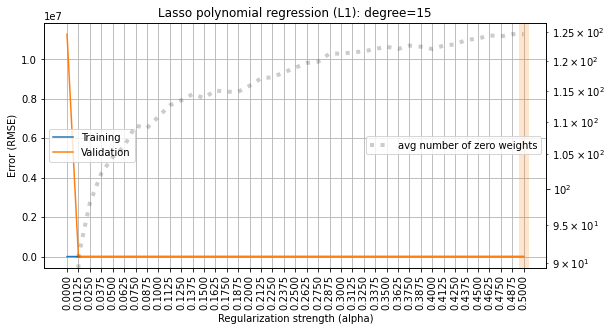

Wall time: 29.3 s


In [35]:
%%time
rmse_train, rmse_valid, avg_zero_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_diabetes(degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_zero_coef.append(np.mean(count_zero_coefs(results['estimator'])))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_zero_coef, custom_label='avg number of zero weights',
                   title='Lasso polynomial regression (L1): degree=15')

In [36]:
avg_zero_coef

[0.0,
 90.8,
 98.0,
 102.2,
 104.6,
 106.2,
 109.4,
 109.0,
 110.8,
 112.6,
 113.4,
 114.4,
 113.8,
 115.0,
 114.8,
 114.8,
 115.8,
 117.0,
 117.2,
 118.0,
 118.8,
 119.6,
 119.8,
 121.2,
 121.2,
 121.4,
 121.6,
 122.0,
 122.4,
 122.0,
 122.6,
 122.4,
 122.0,
 122.6,
 122.8,
 123.6,
 123.8,
 124.4,
 124.2,
 124.6,
 124.6]

#### L2

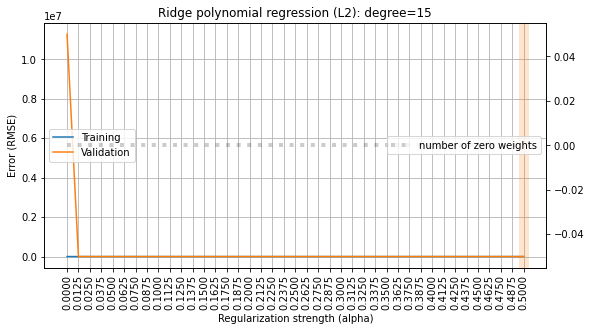

Wall time: 4.43 s


In [37]:
%%time
rmse_train, rmse_valid, zero_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model_diabetes(degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    zero_coef.append(np.mean(count_zero_coefs(results['estimator'])))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=zero_coef, custom_scale='linear', custom_label='number of zero weights',
                   title='Ridge polynomial regression (L2): degree=15')

In [38]:
zero_coef

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

#### Summary

***We can see the following:***

- avg number of zero coefficients for L1 more for all non-zero alphas.
- in fact there is no zero coefficients for L2
- avg number of zero coefficients for L1 increases with increase of regularization parameter alpha

Points above confirm that L1 more likely produces 0 coefficients. It means that Lasso regularization is more effective in feature selection as it more likely produces zero coefficients.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [39]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


In [40]:
def make_model_scaling(use_scaling=True, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
        
    pipeline = Pipeline([('reg', regressor)])
    
    if use_scaling:
        pipeline.steps.insert(0, ['sca', StandardScaler()])
    
    return pipeline

***Let's build models with scaling and without scaling and compare metrics and model coefficients***

#### L1

In [41]:
rmse_train, rmse_valid, not_scaled_weights = [], [], []
results_with_no_scale = cross_validate(make_model_scaling(use_scaling=False, penalty='L1', alpha=1), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')

rmse_train.append(-np.mean(results_with_no_scale['train_score']))
rmse_valid.append(-np.mean(results_with_no_scale['test_score']))
for model in results_with_no_scale['estimator']:
    not_scaled_weights.append(model['reg'].coef_)

In [42]:
print(f'RMSE train: {rmse_train}')
print(f'RMSE valid: {rmse_valid}')

RMSE train: [6.418201456596998]
RMSE valid: [6.824356344081375]


In [43]:
rmse_train, rmse_valid, scaled_weights = [], [], []
results_with_scale = cross_validate(make_model_scaling(use_scaling=True, penalty='L1', alpha=1), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')

rmse_train.append(-np.mean(results_with_scale['train_score']))
rmse_valid.append(-np.mean(results_with_scale['test_score']))
for model in results_with_scale['estimator']:
    scaled_weights.append(model['reg'].coef_)

In [44]:
print(f'RMSE train: {rmse_train}')
print(f'RMSE valid: {rmse_valid}')

RMSE train: [4.1206446308132145]
RMSE valid: [4.217621666913504]


In [45]:
print(f'coefficients without scaling: {np.mean(not_scaled_weights, axis=0)}')
print(f'coefficients with scaling: {np.mean(scaled_weights, axis=0)}')

coefficients without scaling: [ 0.         -0.00022985 -0.01740164]
coefficients with scaling: [4.13775487 0.         0.        ]


***We can observe amazing thing! For the not scaled data the L1 model produced zero coefficient for feature x which was used to generate y labels. At the same time L1 model produced non-zero weights for noise features. This happened because of the different scales of the features. Model didn't catch dependency of feature x due to small values relatively to noisy features. Speaking about scaled data we have opposite situation. Model produced zero weights for noisy features and non-zero weight for x feature. Obviousely model based on not scaled data will be biased which is confirmed by RMSE error values. Both train and valid RMSE are better for scaled data.***

#### L2

In [46]:
rmse_train, rmse_valid, not_scaled_weights = [], [], []
results_with_no_scale = cross_validate(make_model_scaling(use_scaling=False, penalty='L2', alpha=1), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')

rmse_train.append(-np.mean(results_with_no_scale['train_score']))
rmse_valid.append(-np.mean(results_with_no_scale['test_score']))
for model in results_with_no_scale['estimator']:
    not_scaled_weights.append(model['reg'].coef_)

In [47]:
print(f'RMSE train: {rmse_train}')
print(f'RMSE valid: {rmse_valid}')

RMSE train: [6.293993191043426]
RMSE valid: [6.693889215748905]


In [48]:
rmse_train, rmse_valid, scaled_weights = [], [], []
results_with_scale = cross_validate(make_model_scaling(use_scaling=True, penalty='L2', alpha=1), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')

rmse_train.append(-np.mean(results_with_scale['train_score']))
rmse_valid.append(-np.mean(results_with_scale['test_score']))
for model in results_with_scale['estimator']:
    scaled_weights.append(model['reg'].coef_)

In [49]:
print(f'RMSE train: {rmse_train}')
print(f'RMSE valid: {rmse_valid}')

RMSE train: [3.9370101044389543]
RMSE valid: [4.241098111646197]


In [50]:
print(f'coefficients without scaling: {np.mean(not_scaled_weights, axis=0)}')
print(f'coefficients with scaling: {np.mean(scaled_weights, axis=0)}')

coefficients without scaling: [ 5.56496262e+00 -2.08190533e-04 -1.76474761e-02]
coefficients with scaling: [ 4.98109673  0.13466666 -0.58970636]


***Regarding L2 the coefficients are not so obvious as for L1. This is expected as L1 more likely produces zero coefficients. However we still can see bias according to the RMSE. Again both train and valid RMSE are better for scaled data.***

#### Summary



***Scaling is important for fitting regularized models as leaving data not scaled may lead to poor model perfomance. The model may consider not relevant features as important and vice versa consider relevant features as not important. It will cause bad generalization on unseen data.***

***The underlying reasons are in the different magnitude of the features which confuses model and doesn't allow to determine the genuine dependencies. Both Lasso and Ridge regressions put constraints on the size of the coefficients associated to each variable. However, this value will depend on the magnitude of each variable. If the magnitudes are different we will penalize weights for the same number but the weights with lower magnitude will suffer more. It may lead to the wrong conclusions***